08227986

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mapimg
import pandas as pd
import cv2
import os
import dlib
import pickle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.preprocessing import image
from sklearn import decomposition
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
from skimage.color import rgb2gray
from skimage.feature import hog
from scipy.spatial import procrustes

Using TensorFlow backend.


In [2]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

In [3]:
def rect_to_dim(rect):
    w = rect.right() - rect.left()
    h = rect.top() - rect.bottom()
    return (w, h)

In [4]:
def create_feature(img):
    face_detect = dlib.get_frontal_face_detector()
    shape_predict = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')
    rects = face_detect(gray, 1)
    num_faces = len(rects)
    
    if num_faces == 0:
        return None

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)
    
    for (i, rect) in enumerate(rects):
        temp_shape = shape_predict(gray, rect)
        temp_shape = shape_to_np(temp_shape)
        (w, h) = rect_to_dim(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
        dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])
    return dlibout

In [5]:
def create_feature_matrix(file_path, df):
    features = []
    labels = []
    image_paths = [os.path.join(file_path, l) for l in os.listdir(file_path)]
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
        feature = feature = hog(img, pixels_per_cell=(6,6))
        if feature is not None:
            features.append(feature)
            temp = file_name.split(".")[0]
            labels.append(df.loc[int(temp), "face_shape"])
    features = np.array(features)
    return features, labels

In [6]:
def calc_label(data_matrix, center_matrix):
    no_data = data_matrix.shape[0]
    K = center_matrix.shape[0]
    label = np.zeros(no_data)
    for i in range(no_data):
        datum = data_matrix[i, :]
        datum = np.reshape(datum, (datum.shape[0], 1))
        dist2centers = np.zeros(K)
        for k in range(K):
            center=center_matrix[k, :]
            center=np.reshape(center, (center.shape[0], 1))
            t1, t2, dist=procrustes(datum, center)
            dist2centers[k]=dist
        label[i] = np.argmin(dist2centers)
    return label.astype(np.int)

In [7]:
def cost_func(data_matrix, center_matrix, labels):
    K = center_matrix.shape[0]
    cost = 0.
    for k in range(K):
        data_index = np.where(labels==k)
        cluster_data=data_matrix[data_index,:]
        cluster_data=np.reshape(cluster_data, (2916, cluster_data.size//2916))[:, 0].reshape((2916,1))
        cluster_center=center_matrix[k,:].reshape((-1, 1))
        for i in range(cluster_data.shape[0]):
            t1, t2, disp = procrustes(cluster_data, cluster_center)
            cost += disp
    cost = cost/K
    return cost

In [8]:
def update_centers(data_matrix, label, K):
    dim = data_matrix.shape[1]
    center_matrix = np.zeros([K, dim])
    for k in range(K):
        index = np.where(label == k)
        cluster_data = data_matrix[index]
        new_center = cluster_data.mean(axis=0)
        center_matrix[k,:] = new_center
    return center_matrix

In [9]:
def newKMeans(data_matrix, K, max_iter):
    no_data = data_matrix.shape[0]
    index = np.arange(no_data)
    np.random.shuffle(index)
    center_matrix = data_matrix[index[:K]]
    label = calc_label(data_matrix, center_matrix)
    cost = cost_func(data_matrix, center_matrix, label)
    Train = True
    iter = 0
    while Train:
        iter += 1
        center_matrix = update_centers(data_matrix, label, K)
        label = calc_label(data_matrix, center_matrix)
        cost = cost_func(data_matrix, center_matrix, label)
        print(f"iter {iter}: cost = {cost}")
        if iter >= max_iter:
            Train = False
    return label, center_matrix

In [17]:
def KNNClassifier(x_train, y_train, x_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train) # Fit KNN model


    Y_pred = neigh.predict(x_test)
    return Y_pred

In [11]:
file_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\img"
labels_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv"

In [12]:
df = pd.read_csv(labels_path)

df = df.drop(columns="Unnamed: 0")
temp = df["file_name"]
df.insert(loc=0, column="file_names", value=temp)
df = df.drop(columns="file_name")
df = df.drop(df.index[1000:])

In [13]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [18]:
temp = train.filter(axis='columns', items= ["file_names", "face_shape"])

filter0 = train.loc[:,"face_shape"] == 0
filter0 = train[filter0]
img0 = filter0["file_names"].iloc[0]
img_path = os.path.join(file_path, img0)
img0 = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
feature0 = create_feature(img0)

filter1 = train.loc[:,"face_shape"] == 1
filter1 = train[filter1]
img1 = filter1["file_names"].iloc[0]
img_path = os.path.join(file_path, img1)
img1 = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
feature1 = create_feature(img1)

filter2 = train.loc[:,"face_shape"] == 2
filter2 = train[filter2]
img2 = filter2["file_names"].iloc[0]
img_path = os.path.join(file_path, img2)
img2 = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
feature2 = create_feature(img2)

filter3 = train.loc[:,"face_shape"] == 3
filter3 = train[filter3]
img3 = filter3["file_names"].iloc[0]
img_path = os.path.join(file_path, img3)
img3 = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
feature3 = create_feature(img3)

filter4 = train.loc[:,"face_shape"] == 4
filter4 = train[filter4]
img4 = filter4["file_names"].iloc[0]
img_path = os.path.join(file_path, img4)
img4 = image.img_to_array(image.load_img(img_path, target_size=(50,50), interpolation='bicubic'))
feature4 = create_feature(img4)

In [14]:
train_features, train_labels = create_feature_matrix(file_path, train)

In [15]:
val_features, val_labels = create_feature_matrix(file_path, validation)

In [97]:
label, center_matrix = newKMeans(features, 5, 20)

iter 1: cost = 2914.718482152645
iter 2: cost = 2914.6235480028618
iter 3: cost = 2912.811037133907
iter 4: cost = 2914.9855257205263
iter 5: cost = 2914.3584397389996
iter 6: cost = 2914.379368356257
iter 7: cost = 2914.379368356257
iter 8: cost = 2914.379368356257
iter 9: cost = 2914.379368356257
iter 10: cost = 2914.379368356257
iter 11: cost = 2914.379368356257
iter 12: cost = 2914.379368356257
iter 13: cost = 2914.379368356257
iter 14: cost = 2914.379368356257
iter 15: cost = 2914.379368356257
iter 16: cost = 2914.379368356257
iter 17: cost = 2914.379368356257
iter 18: cost = 2914.379368356257
iter 19: cost = 2914.379368356257
iter 20: cost = 2914.379368356257


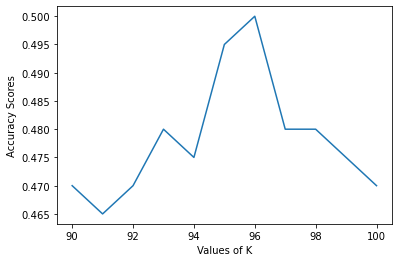

In [23]:
scores = []
Ks = []
for k in range(90,101):
    Y_pred = KNNClassifier(train_features, train_labels, val_features, k)
    score = metrics.accuracy_score(val_labels, Y_pred)
    scores.append(score)
    Ks.append(k)
plt.plot(Ks, scores)
plt.xlabel('Values of K')
plt.ylabel('Accuracy Scores')
plt.show()

In [24]:
print(scores)

[0.47, 0.465, 0.47, 0.48, 0.475, 0.495, 0.5, 0.48, 0.48, 0.475, 0.47]
